### imports

In [174]:
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from config import config

### Get the pandas dataframes from sql

In [31]:
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)

        return conn

        
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [34]:
conn = connect()

Connecting to the PostgreSQL database...


In [154]:
sql_query = """
select * 
from fact_table f, event ev, population p, education ed, country c, health h, month m, quality_of_life q
where f.event_key = ev.event_key and f.population_key = p.population_key and f.education_key = ed.education_key and 
f.country_key = c.country_key and f.health_key = h.health_key and f.month_key = m.month_key and f.quality_of_life_key = q.quality_of_life_key
"""

df = pd.DataFrame(pd.read_sql(sql_query, conn))

In [36]:
df.head()

,month_key,country_key,education_key,population_key,quality_of_life_key,health_key,event_key,quality_of_life,development_index,human_development_index,...,unemployment_rate_f,unemployment_rate_m,unemployment_rate_t,maternal_leave_benefits,access_to_electricity_total,access_to_electricity_urban,access_to_electricity_rural,part_time_employment_t,part_time_employment_f,part_time_employment_m
0,4,0,0,0,0,0,26,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
1,5,0,0,0,0,0,22,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
2,6,0,0,0,0,0,23,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
3,7,0,0,0,0,0,24,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
4,8,0,0,0,0,0,21,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83


## Part A1
### Getting a "feel" for the data

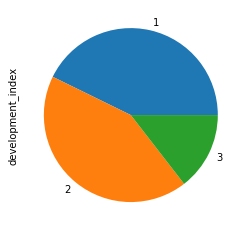

In [78]:
# make a pie chart to see the distribution of the development index
plt1 = df['development_index'].value_counts().plot(kind='pie')


C:\Users\Nicholas\AppData\Local\Temp/ipykernel_5292/1136854827.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt2.get_figure().show()


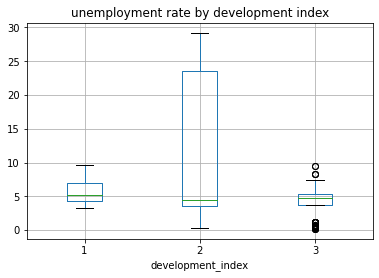

In [88]:
# make a boxplot comparing the development index and the life expectancy
plt2 = df.boxplot(column='unemployment_rate_t', by='development_index')
plt2.set_title('unemployment rate by development index')
plt2.get_figure().suptitle('')
plt2.get_figure().show()


C:\Users\Nicholas\AppData\Local\Temp/ipykernel_5292/743161887.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt3.get_figure().show()


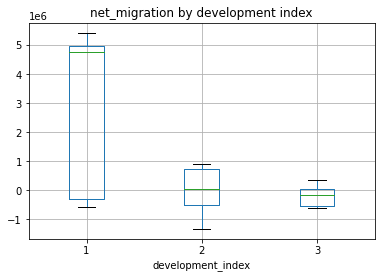

In [80]:
# make a boxplot comparing the development index and the net migration
plt3 = df.boxplot(column='net_migration', by='development_index')
plt3.set_title('net_migration by development index')
plt3.get_figure().suptitle('')
plt3.get_figure().show()

C:\Users\Nicholas\AppData\Local\Temp/ipykernel_5292/754714647.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt4.get_figure().show()


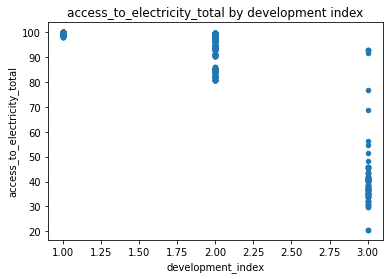

In [81]:
# make a scatter plot to compare the development index and access to drinking water
plt4 = df.plot(kind='scatter', x='development_index', y='access_to_electricity_total')
plt4.set_title('access_to_electricity_total by development index')
plt4.get_figure().suptitle('')
plt4.get_figure().show()

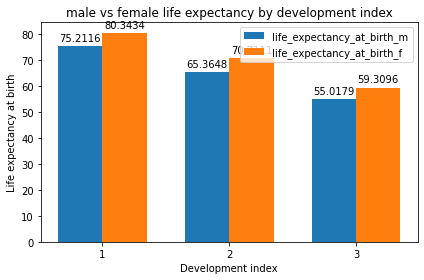

In [89]:
# graph the differences in male and female life expectencies with respect to the development index
df.groupby('development_index')['life_expectancy_at_birth_t'].mean().to_list()

labels = ['1','2','3']
life_expectancy_at_birth_m_means = df.groupby('development_index')['life_expectancy_at_birth_m'].mean().to_list()
life_expectancy_at_birth_f_means = df.groupby('development_index')['life_expectancy_at_birth_f'].mean().to_list()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, life_expectancy_at_birth_m_means, width, label='life_expectancy_at_birth_m')
rects2 = ax.bar(x + width/2, life_expectancy_at_birth_f_means, width, label='life_expectancy_at_birth_f')

ax.set_ylabel('Life expectancy at birth')
ax.set_xlabel('Development index')
ax.set_title('male vs female life expectancy by development index')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


## Part A2

### Feature selection:

The features we chose are:
life_expectancy_at_birth_t\
life_expectancy_at_birth_m\
life_expectancy_at_birth_f\
net_migration\
rural_population\
urban_population\
number_of_infant_deaths\
number_of_stillbirths\
unemployment_rate_t\
unemployment_rate_m\
unemployment_rate_f\
part_time_employment_t\
access_to_electricity_total\
access_to_drinking_water\
access_to_sanitation\
immunization_hepb3\
immunization_dpt\
immunization_measles\
immunization_pol3\
domestic_general_government_health_expenditure\
population_growth_annual\
pop_compulsory_school_age_total\
disaster_type\
disaster_subgroup\

development_index

In [156]:
df_reduced = df[['life_expectancy_at_birth_t',
'life_expectancy_at_birth_m',
'life_expectancy_at_birth_f',
'net_migration',
'rural_population',
'urban_population',
'number_of_infant_deaths',
'number_of_stillbirths',
'unemployment_rate_t',
'unemployment_rate_m',
'unemployment_rate_f',
'part_time_employment_t',
'access_to_electricity_total',
'access_to_drinking_water',
'access_to_sanitation',
'immunization_hepb3',
'immunization_dpt',
'immunization_measles',
'immunization_pol3',
'domestic_general_government_health_expenditure',
'population_grown_annual',
'pop_compuslory_school_age_total',
'disaster_type',
'disaster_subgroup',
'development_index']]

### Handling categorical attributes through one-hot encoding

In [171]:
df_ohe = pd.get_dummies(df_reduced)

df_ohe.head()

,life_expectancy_at_birth_t,life_expectancy_at_birth_m,life_expectancy_at_birth_f,net_migration,rural_population,urban_population,number_of_infant_deaths,number_of_stillbirths,unemployment_rate_t,unemployment_rate_m,...,disaster_type_Storm,disaster_type_Transport accident,disaster_type_Volcanic activity,disaster_type_Wildfire,disaster_subgroup_Biological,disaster_subgroup_Climatological,disaster_subgroup_Geophysical,disaster_subgroup_Hydrological,disaster_subgroup_Meteorological,disaster_subgroup_Technological
0,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,0,0,0,0,0,0,1
1,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,0,0,0,0,1,0,0
2,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,1,0,1,0,0,0,0
3,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,1,0,1,0,0,0,0
4,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,0,0,0,0,1,0,0


### Handling of missing values
Most of this was handled in deliverable 2 but we still have some null values so we will impute them with pandas

In [172]:

df_ohe['number_of_stillbirths'].fillna(df_ohe['number_of_stillbirths'].mean(), inplace=True)
df_ohe['part_time_employment_t'].fillna(df_ohe['part_time_employment_t'].mean(), inplace=True)
df_ohe['immunization_hepb3'].fillna(df_ohe['immunization_hepb3'].mean(), inplace=True)
df_ohe['domestic_general_government_health_expenditure'].fillna(df_ohe['domestic_general_government_health_expenditure'].mean(), inplace=True)
df_ohe['pop_compuslory_school_age_total'].fillna(df_ohe['pop_compuslory_school_age_total'].mean(), inplace=True)


[]

### Normalization of numeric attributes to ensure all attributes are of equal importance during learning

In [175]:
scaler = preprocessing.MinMaxScaler()
names = df_ohe.columns.to_list()
df_ohe[names] = scaler.fit_transform(df_ohe[names])

df_ohe.head()

,life_expectancy_at_birth_t,life_expectancy_at_birth_m,life_expectancy_at_birth_f,net_migration,rural_population,urban_population,number_of_infant_deaths,number_of_stillbirths,unemployment_rate_t,unemployment_rate_m,...,disaster_type_Storm,disaster_type_Transport accident,disaster_type_Volcanic activity,disaster_type_Wildfire,disaster_subgroup_Biological,disaster_subgroup_Climatological,disaster_subgroup_Geophysical,disaster_subgroup_Hydrological,disaster_subgroup_Meteorological,disaster_subgroup_Technological
0,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Part B. Classification

The label of our choice is Development-Index

### Decision Tree

### Gradient Boosting

### Random Forest